In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [38]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [39]:
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.street, prefix="street", drop_first=True).columns)

In [40]:
#create variable that includes total number of baths to see if this improves the model
df['total_bath'] = df['fullbath']+df['halfbath']+df['bsmtfullbath']+df['bsmthalfbath']
df['outdoor'] = df['openporchsf']*df['lotarea']*df['wooddecksf']

In [20]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set
X = df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [15]:
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     383.1
Date:                Mon, 15 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:49:10   Log-Likelihood:                -13972.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1157   BIC:                         2.802e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.039e+05   2.06e+04     -5.037      0.000   -1.44e+05   -6.34e+04
overallqual  2.433e+04   1244.706     19.548      0.000    2.19e+04    2.68e+04
grlivarea      43.3745      2.745     15.800      0.000      37.988      48.760
garagecars   1.407e+04   3409.600      4.126      0.000    7379.047    2.08e+04
garagearea     17.5210     11.560      1.516      0.130      -5.161      40.203
totalbsmtsf    23.4504      3.183      7.368      0.000      17.206      29.695
mszoning_FV  1.933e+04    1.5e+04      1.289      0.198   -1.01e+04    4.88e+04
mszoning_RH  7305.5078   1.72e+04      0.426      0.670   -2.63e+04     4.1e+04
mszoning_RL  2.429e+04   1.39e+04      1.747      0.081   -2983.478    5.16e+04
mszoning_RM  2864.3070   1.41e+04      0.203      0.839   -2.48e+04    3.05e+04
street_Pave -8177.6681   1.74e+04     -0.470      0.639   -4.23e+04     2.6e+04
==============================================================================
Omnibus:                      355.774   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30190.746
Skew:                          -0.383   Prob(JB):                         0.00
Kurtosis:                      27.895   Cond. No.                     5.62e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

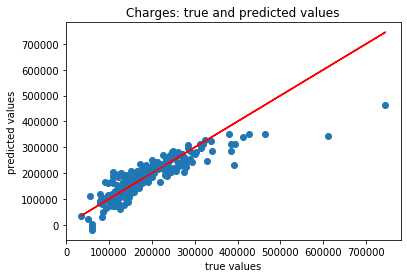

Mean absolute error of the prediction is: 25546.803828588712
Mean squared error of the prediction is: 1559083821.9730315
Root mean squared error of the prediction is: 39485.23549344782
Mean absolute percentage error of the prediction is: 15.551420347537723


In [16]:
#Make predictions
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



This model fails massively for higher priced houses. The next iteration tries again with the added bath and year remodelled data from the improved model.

In [45]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set
X = df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'mszoning_FV', 'mszoning_RL',
                     'total_bath', 'yearremodadd']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [46]:
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     500.3
Date:                Mon, 15 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:56:09   Log-Likelihood:                -13953.
No. Observations:                1168   AIC:                         2.792e+04
Df Residuals:                    1159   BIC:                         2.797e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.679e+05   1.29e+05     -5.169      0.000   -9.21e+05   -4.14e+05
overallqual   2.149e+04   1291.837     16.633      0.000     1.9e+04     2.4e+04
grlivarea       39.3699      3.002     13.115      0.000      33.480      45.259
garagecars    1.606e+04   1951.037      8.229      0.000    1.22e+04    1.99e+04
totalbsmtsf     25.3509      3.046      8.322      0.000      19.374      31.327
mszoning_FV   6816.6464   6255.226      1.090      0.276   -5456.188    1.91e+04
mszoning_RL   1.718e+04   3202.144      5.364      0.000    1.09e+04    2.35e+04
total_bath    6487.3246   1668.429      3.888      0.000    3213.845    9760.804
yearremodadd   288.7947     66.750      4.327      0.000     157.831     419.758
==============================================================================
Omnibus:                      342.407   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30944.797
Skew:                          -0.253   Prob(JB):                         0.00
Kurtosis:                      28.211   Cond. No.                     3.24e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

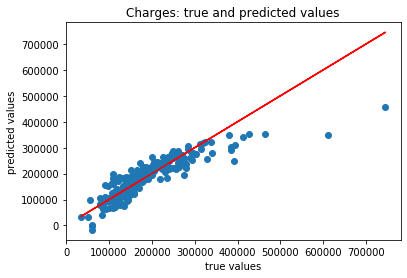

Mean absolute error of the prediction is: 24368.227671324392
Mean squared error of the prediction is: 1457713600.722475
Root mean squared error of the prediction is: 38180.015724492245
Mean absolute percentage error of the prediction is: 14.378364847363812


In [47]:
#Make predictions
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [50]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set
X = df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf'] + dummy_column_names]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [51]:
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     424.9
Date:                Mon, 15 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:58:05   Log-Likelihood:                -13973.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1158   BIC:                         2.802e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.005e+05   2.05e+04     -4.900      0.000   -1.41e+05   -6.03e+04
overallqual  2.419e+04   1242.047     19.479      0.000    2.18e+04    2.66e+04
grlivarea      43.7243      2.737     15.976      0.000      38.354      49.094
garagecars   1.829e+04   1964.356      9.313      0.000    1.44e+04    2.21e+04
totalbsmtsf    24.5366      3.103      7.908      0.000      18.449      30.624
mszoning_FV   1.84e+04    1.5e+04      1.227      0.220    -1.1e+04    4.78e+04
mszoning_RH  6113.0229   1.71e+04      0.357      0.721   -2.75e+04    3.97e+04
mszoning_RL  2.281e+04   1.39e+04      1.644      0.101   -4418.646       5e+04
mszoning_RM  1214.2547   1.41e+04      0.086      0.931   -2.64e+04    2.88e+04
street_Pave -1.004e+04   1.74e+04     -0.578      0.563   -4.41e+04     2.4e+04
==============================================================================
Omnibus:                      339.805   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27220.609
Skew:                          -0.304   Prob(JB):                         0.00
Kurtosis:                      26.642   Cond. No.                     5.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

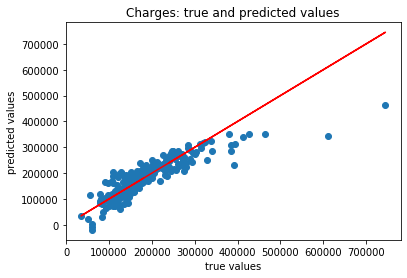

Mean absolute error of the prediction is: 25698.40029906694
Mean squared error of the prediction is: 1560222128.7469587
Root mean squared error of the prediction is: 39499.64719775303
Mean absolute percentage error of the prediction is: 15.661233556977106


In [52]:
#Make predictions
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [53]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set
X = df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'total_bath', 'yearremodadd']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [54]:
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     645.5
Date:                Mon, 15 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:58:56   Log-Likelihood:                -13969.
No. Observations:                1168   AIC:                         2.795e+04
Df Residuals:                    1161   BIC:                         2.799e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.613e+05    1.3e+05     -5.094      0.000   -9.16e+05   -4.07e+05
overallqual   2.118e+04   1296.816     16.329      0.000    1.86e+04    2.37e+04
grlivarea       37.9928      2.991     12.701      0.000      32.124      43.862
garagecars    1.693e+04   1969.029      8.596      0.000    1.31e+04    2.08e+04
totalbsmtsf     28.9830      3.006      9.643      0.000      23.086      34.880
total_bath    8166.8077   1637.029      4.989      0.000    4954.942    1.14e+04
yearremodadd   289.6962     67.074      4.319      0.000     158.096     421.296
==============================================================================
Omnibus:                      364.557   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31705.100
Skew:                          -0.425   Prob(JB):                         0.00
Kurtosis:                      28.510   Cond. No.                     3.21e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

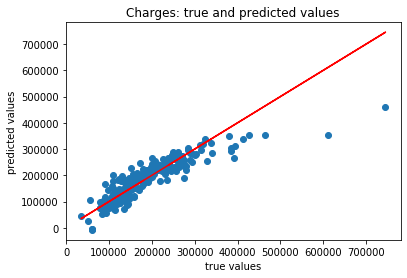

Mean absolute error of the prediction is: 24820.38974294448
Mean squared error of the prediction is: 1465054826.6889398
Root mean squared error of the prediction is: 38276.03462597634
Mean absolute percentage error of the prediction is: 15.003124427931363


In [55]:
#Make predictions
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [86]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set
X = df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'firstflrsf', 'total_bath', 'yearbuilt',
        'yearremodadd']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [87]:
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     492.4
Date:                Mon, 15 Jul 2019   Prob (F-statistic):               0.00
Time:                        20:05:49   Log-Likelihood:                -13960.
No. Observations:                1168   AIC:                         2.794e+04
Df Residuals:                    1159   BIC:                         2.798e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.846e+05   1.45e+05     -5.426      0.000   -1.07e+06   -5.01e+05
overallqual   2.101e+04   1351.315     15.550      0.000    1.84e+04    2.37e+04
grlivarea       36.1295      3.664      9.860      0.000      28.941      43.318
garagecars    1.498e+04   2038.860      7.349      0.000     1.1e+04     1.9e+04
totalbsmtsf     15.6888      4.582      3.424      0.001       6.699      24.679
firstflrsf      19.1756      5.452      3.517      0.000       8.478      29.873
total_bath    8003.0968   1807.488      4.428      0.000    4456.783    1.15e+04
yearbuilt      117.1427     57.961      2.021      0.044       3.422     230.864
yearremodadd   235.1532     70.573      3.332      0.001      96.687     373.619
==============================================================================
Omnibus:                      361.491   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32392.447
Skew:                          -0.394   Prob(JB):                         0.00
Kurtosis:                      28.787   Cond. No.                     4.69e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

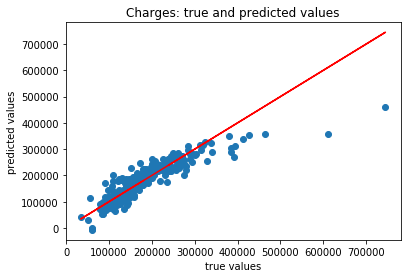

Mean absolute error of the prediction is: 24507.185382244996
Mean squared error of the prediction is: 1439619877.545969
Root mean squared error of the prediction is: 37942.32303834293
Mean absolute percentage error of the prediction is: 14.7384272727418


In [88]:
#Make predictions
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

I was able to get the model 'more accurate' in terms of better R-squared and lower error in the prediction, BUT the predictive value for the model continues to be very bad for higher end homes. At this point, it seems like more data would be needed to make this model better?